In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [3]:
# import fmks
import numpy as np
# import numpy.polynomial.legendre as leg
# import pymks
import legendre
import matplotlib.pyplot as plt
import ch_tester
# import numpy.fft as fft
# from scipy.linalg import lstsq
# from sklearn.linear_model import LinearRegression
import mks_localisation

In [4]:
def draw(x):
    plt.imshow(x)
    plt.colorbar()
    plt.show()
    
    
# def axes_(arr):
#     return (np.arange(arr.ndim - 1)+1)


# def axes_shape(arr):
#     return arr.shape


# def fit(X, y, domain, n_states, discretize):
    
# #     discretize = legendre.legendre_basis
#     X_ = discretize(X, domain, n_states)
#     _axes=axes_(X)
#     FX = fft.fftn(X_, axes=_axes)
#     Fy = fft.fftn(y,  axes=_axes)
    
#     Fkernel = np.zeros(FX.shape[1:], dtype=np.complex)
#     lstsq_rcond = np.finfo(float).eps*1e4
#     s0 = (slice(None),)
#     for ijk in np.ndindex(FX.shape[1:-1]):
#         s1 = s0
#         Fkernel[ijk + s1] = lstsq(FX[s0 + ijk + s1], Fy[s0 + ijk],
#                                   lstsq_rcond)[0]
#     return Fkernel


# def predict(X, coeff, domain, n_states, discretize): 
    
# #     discretize = legendre.legendre_basis
#     X_  = discretize(X, domain, n_states)
#     FX  = fft.fftn(X_, axes=axes_(X))
#     Fy  = np.sum(FX*coeff[None], axis = -1)
#     y   = fft.ifftn(Fy, axes=axes_(X)).real
#     return y


# def coeff_real(coeff, _axes):
#     return fft.ifftshift(fft.ifftn(coeff, axes = _axes)).real


def make_dataset(seed, tsteps=1, shape=(1, 51, 51), dx = 0.1, dt=1e-2, gamma=1.):
    solver = ch_tester.ch_solver
    np.random.seed(seed)
    X0 = np.random.normal(loc=0.0, scale = 1.0, size=shape)*1.e-1
    X  = X0.copy() 
    for i in range(tsteps):
        X = solver(X, dx = 0.1, dt=1e-2, gamma= 1.)
    return X0, X

In [5]:
%%time
X_train, y_train = make_dataset(seed=99, tsteps=10, shape=(200,51,51), dx=0.1, dt=1e-2, gamma=1.)

CPU times: user 1.44 s, sys: 8 ms, total: 1.45 s
Wall time: 1.45 s


In [6]:
%%time
X_test, y_test = make_dataset(seed=81, tsteps=10, shape=(10,51,51), dx=0.1, dt=1e-2, gamma=1.)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 86.6 ms


In [8]:
%%time
n_states_ = 10
domain_   = (-1, 1)
discretize = legendre.legendre_basis
coeff_    = mks_localisation.fit(X=X_train, y=y_train, domain=domain_, n_states=n_states_, discretize=discretize)
y_predict = mks_localisation.predict(X=X_test, coeff=coeff_, domain=domain_, n_states=n_states_, discretize=discretize)

CPU times: user 2.57 s, sys: 564 ms, total: 3.14 s
Wall time: 2.25 s


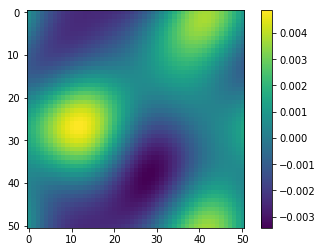

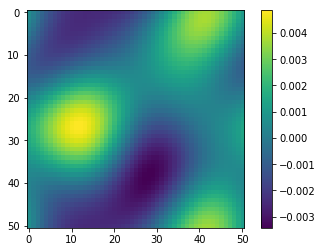

In [9]:
draw(y_test[0])
draw(y_predict[0])

In [8]:
import pymks

In [14]:
n_states = 2
n_spaces = 81
n_samples = 400

#    Define a filter function.

def filter(x):
    return np.where(x < 10, 
                    np.exp(-abs(x)) * np.cos(x * np.pi),
                    np.exp(-abs(x - 20)) * np.cos((x - 20) * np.pi))

#    Use the filter function to construct some coefficients.

coef_ = np.linspace(1, 0, n_states)[None,:] * filter(np.linspace(0, 20,
                                                                 n_spaces))[:,None]
Fcoef_ = np.fft.fft(coef_, axis=0)

#    Make some test samples.

np.random.seed(2)
X = np.random.random((n_samples, n_spaces))

#    Construct a response with the `Fcoef_`.

H  = np.linspace(0, 1, n_states)
X_ = np.maximum(1 - abs(X[:,:,None] - H) / (H[1] - H[0]), 0)
FX = np.fft.fft(X_, axis=1)
Fy = np.sum(Fcoef_[None] * FX, axis=-1)
y  = np.fft.ifft(Fy, axis=1).real

#    Use the `MKSLocalizationModel` to reconstruct the coefficients

from pymks.bases import PrimitiveBasis
from pymks import MKSLocalizationModel

prim_basis = PrimitiveBasis(n_states, [0, 1])
model = MKSLocalizationModel(basis=prim_basis)
model.fit(X, y)

#    Check the result

assert np.allclose(np.fft.fftshift(coef_, axes=(0,)), model.coef_)


In [17]:
np.random.seed(3)
X = np.random.random((1, 3, 3))
# leg_basis = LegendreBasis(2, [0, 1])
# model = MKSLocalizationModel(basis=leg_basis)
discretize = legendre.legendre_basis
X_ = discretize(X, domain = (0,1), n_states=2)
FX = np.fft.fftn(X_, axes=(1, 2))


FXtest = np.array([[[[4.50000000+0.j, -0.79735949+0.],
                     [0.00000000+0.j, -1.00887157-1.48005289j],
                     [0.00000000+0.j, -1.00887157+1.48005289j]],
                    [[0.00000000+0.j, 0.62300683-4.97732233j],
                     [0.00000000+0.j, 1.09318216+0.10131035j],
                     [0.00000000+0.j, 0.37713401+1.87334545j]],
                    [[0.00000000+0.j, 0.62300683+4.97732233j],
                     [0.00000000+0.j, 0.37713401-1.87334545j],
                     [0.00000000+0.j, 1.09318216-0.10131035j]]]])
assert np.allclose(FX, FXtest)